## 2D SSN simulation ~  JAX IMPLEMENTATION

Changes required by JAX:
- jax.random vs numpy.random
- introduction of key variables to operate in random **
- np.chararray substituted -> created separate boolean array after locating indices in a list because jax doesnt support character arrays

In [1]:
#import numpy as np
import jax.numpy as np
from jax import jit
import matplotlib.pyplot as plt
import time, os, json
import pandas as pd
from scipy import stats 
from tqdm import tqdm
import seaborn as sns
from jax import random

from SSN_classes_jax import SSN2DTopoV1_AMPAGABA_ONOFF
from util import GaborFilter, BW_Grating

## Parameters for network initialisation

Resolution of SSN grid: 2.8125 pixels / degree

In [2]:
class ssn_pars():
    n = 2
    k = 0.04
    tauE = 30 # in ms
    tauI = 10 # in ms
    psi = 0.774
    tau_s = np.array([5, 7, 100]) #in ms, AMPA, GABA, NMDA current decay time constants
    

# with mm_scale=1, The following match "fixed_params" of  'Fig4_data-retinoHists-samples1000_TauCorr5_2020-04-11.json'
class grid_pars():
    gridsize_Nx = 9 # grid-points across each edge # gives rise to dx = 0.8 mm
    gridsize_deg = 2 * 1.6 # edge length in degrees
    magnif_factor = 2  # mm/deg
    hyper_col = 0.8 # mm   #CHANGES VARIATION IN THE TONOTOPIC MAP
    sigma_RF = 0.4 # deg (visual angle)

# Caleb's params for the full (with local) model:
Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
gE, gI = 0.57328625, 0.26144141
sigEE, sigIE = 0.2, 0.40
sigEI, sigII = .09, .09
conn_pars = dict(
    PERIODIC = False,
    p_local = [.4, 0.7], # [p_local_EE, p_local_IE],
    sigma_oris = 1000) # sigma_oris

make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi
J_2x2 = make_J2x2(*Js0)
s_2x2 = np.array([[sigEE, sigEI],[sigIE, sigII]])

#Reparametrize to positive
signs = np.array(([1, -1], [1, -1]))
J_2x2 = signs*np.exp((J_2x2))

s_2x2_2 = np.exp(np.log(s_2x2))

#Gabor parameters 
sigma_g= 0.5
k= np.pi/(6*sigma_g)

#Parameters shared with stimuli
general_pars = dict(k=k, edge_deg=3.2,  degree_per_pixel=0.05)

#Parameters exclusive to Gabor filters
filter_pars = dict(sigma_g = sigma_g, conv_factor = grid_pars.magnif_factor)

#Concatenate all parameters
filter_pars.update(general_pars) 


## Initialise network

In [3]:
#Create network
ssn = SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars, grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)

Average A is 0.0008299059719974085


Iterate over neurons in SSN map

## Jia stimuli

Import stimuli. Parameters to specify:
- orientation -  in degrees from vertical (anti clockwise) - HAD TO ROTATE CREATION OF GABOR FILTERS!
- size - in pixels 227*227
- outer radius + inner radius - in degrees
- pixels per degree
- grating contrast - up to 1 (*100 in SSN code)
- snr - 0<= snr <= 1
- phase - in degrees
- spatial frequency - in degrees (need to multiply k* dx_i - dx_i in degrees/pixel)

In [4]:
#Stimuli parameters - all in degrees
key = random.PRNGKey(86)
jitter_val = 5
jitter =random.uniform(key, minval=- jitter_val , maxval= jitter_val)
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.99, jitter = jitter)
stimuli_pars.update(general_pars) #add size and resolution params from Gabor filters

#Create reference stimuli
ori_ref = 10
test_stimuli=BW_Grating(ori_deg = ori_ref,  **stimuli_pars).BW_image()

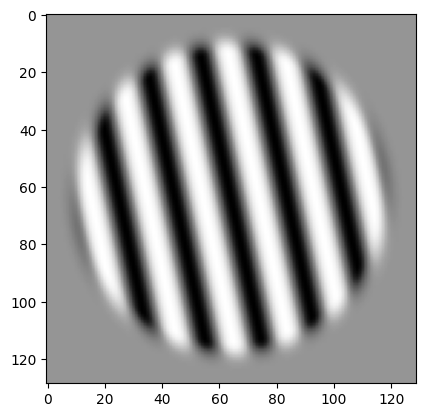

In [5]:
plt.imshow(test_stimuli, cmap='Greys')

# -> Apply filters to stimuli

## Input to network

In [6]:
#create stimulus at required orientation
grating_pars=dict(outer_radius=3, inner_radius=2.5, degree_per_pixel=0.05, edge_deg=3.2, grating_contrast=0.9 ,k=k)
grating=BW_Grating(ori_deg=10, snr = 1, **grating_pars,)
test_stimuli=grating.BW_image()

#Multiply all filters by the stimuli
output_gabor=np.matmul(ssn.gabor_filters, test_stimuli.ravel())*ssn.A

#Rectify input
SSN_input=np.maximum(0, output_gabor)

In [7]:
#Convergence parameters
dt = 1
xtol = 1e-5
Tmax = 600

#Find fixed point using input
r_init = np.zeros(SSN_input.shape[0])
r_fps, CONVG = ssn.fixed_point_r(SSN_input, r_init=r_init, Tmax=Tmax, dt=dt, xtol=xtol)


 Warning 1: reached Tmax=600, before convergence to fixed point.
       max(abs(dx./max(abs(xvec), 1.0))) = nan,   xtol=1e-05.

Did not reach fixed point.


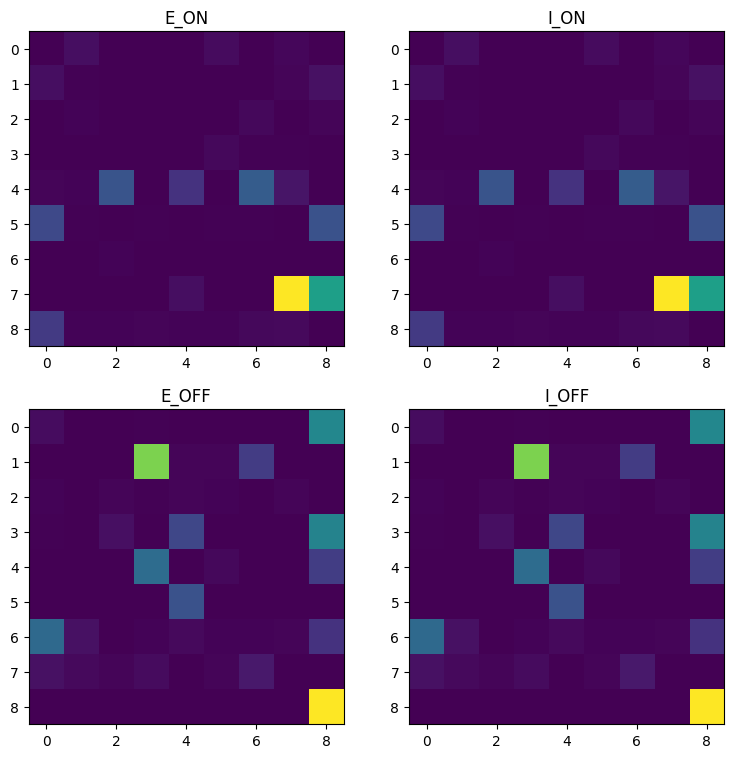

In [8]:
ssn.response_plots(SSN_input)